In [237]:
import nltk 
from nltk.tokenize import word_tokenize
from bertopic import BERTopic
import pandas as pd
import chardet
from sentence_transformers import SentenceTransformer

import random
import numpy as np
import torch

import openai
import tiktoken
from bertopic.representation import OpenAI

import sqlite3

random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

# Topic Modelling based on sampled data

#### Read file into DataFrame


In [ ]:
# import json
# file_path = r"C:\\Users\\Liu Shi Peng\\Documents\\chat_messages_202408081004.json"

# with open(file_path, "rb") as f:
#     json_file = json.load(f)

# df = pd.DataFrame(list(json_file.values())[0])
# docs = df['user_query'].tolist()
# len(docs)

In [7]:
file_path = r"C:\\Users\\Liu Shi Peng\\Documents\\feb_2_aug_topic_classification\\tgpt_feb_2_jul_topic_mapping_by_llama.csv"

df = pd.read_csv(file_path)
d.head()

Unnamed: 0                            message_id  \
0           0  d990990d-d5a5-44e4-8766-335c4a61c962   
1           1  6ccc3b25-06cc-4cc8-97e5-8a7d726b338d   
2           2  7089f724-4a67-49b2-9177-b2148a85d01f   
3           3  3c6b9f2b-86db-4828-b217-6bc9a568c083   
4           4  2dacb393-c8bf-4578-b691-b89df9a3eeba   

                                          user_query  \
0  How Likely could I buy 100 call option at 205 ...   
1  Give me a trade from tomorrow, options which e...   
2  How likely would it be to sell them if nvda hi...   
3  Ok take out the 1$ part and tell me a good ent...   
4        Best call options for nvda expiring July 19   

                        topic  
0  Options Trading Strategies  
1  Options Trading Strategies  
2  Options Trading Strategies  
3  Options Trading Strategies  
4  Options Trading Strategies

In [9]:
df.shape

(324725, 4)

In [13]:
# slice only 5000 messages for initial modelling demo
query_list = df['user_query'].tolist()
docs = query_list[:10000]
docs[:3]

['How Likely could I buy 100 call option at 205 stirike price expiring July 5',
 'Give me a trade from tomorrow, options which expires tomorrow. High risk high reward. Not planning on holding it for more than 2 hours. Option price under a $ ',
 'How likely would it be to sell them if nvda hits 130 ']

### create embeddings

In [ ]:
# The SentenceTransformers library focuses on generating contextual embeddings that capture the semantic meaning of sentences. 
# It does not perform tasks like stemming, lemmatization, or manual stop word removal as these are not necessary for the model's purpose.
# For better results, you might want to perform some preprocessing on your text before generating embeddings. This can include:
# Removing or replacing URLs, special characters, and excessive whitespace.
# Handling any specific text issues relevant to your data.

In [219]:
# sentence transformers
embedding_model = SentenceTransformer('intfloat/multilingual-e5-large-instruct') #'intfloat/multilingual-e5-large-instruct', 'all-MiniLM-L6-v2', 'multilingual-e5-base'
embeddings = embedding_model.encode(docs, show_progress_bar=True)

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

In [221]:
with open("C:\\Users\\Liu Shi Peng\\Documents\\feb_2_aug_topic_classification\\embeddings_feb_2_aug_10k_e5_0816.npy", 'wb') as f:
    np.save(f, embeddings)

In [17]:
# embeddings = np.load("C:\\Users\\Liu Shi Peng\\Documents\\embeddings_100k_miniLM_0808.npy")
# embeddings.shape

In [223]:
from umap import UMAP
umap_model = UMAP(n_components=2, metric='cosine', random_state=42)
umap_embeddings = umap_model.fit_transform(embeddings)
with open("C:\\Users\\Liu Shi Peng\\Documents\\embeddings_feb_2_aug_10k_e5_by_umap_0816.npy", 'wb') as f:
    np.save(f, umap_embeddings)

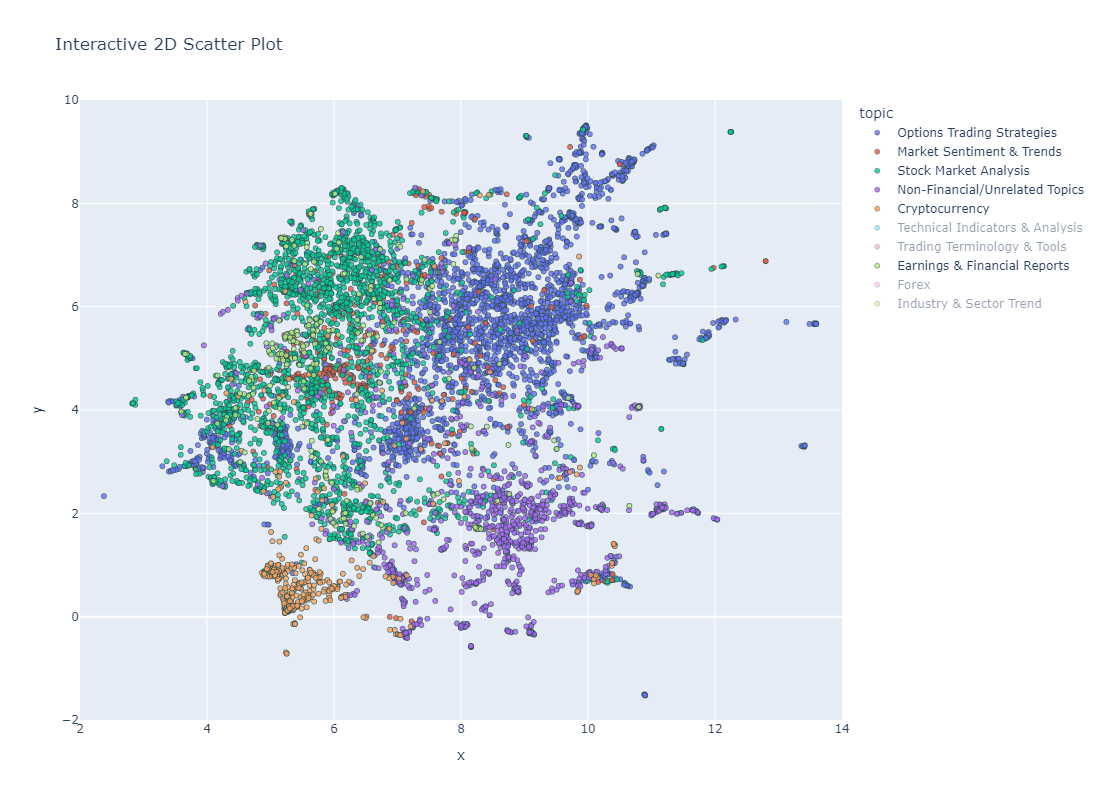

In [235]:
df_docs = pd.DataFrame(umap_embeddings, columns = ['x', 'y'])
df_docs_with_topic = df_docs
df_docs_with_topic['topic'] = df['topic'][:10000]
df_docs_with_topic['user_query'] = df['user_query'][:10000]

import matplotlib.pyplot as plt
import seaborn as sns

# Plotting
# fig = plt.figure(figsize=(15,10))
# sns.scatterplot(x='x', y='y', hue='topic', palette='Set1', data=df_docs_with_topic, s=30, edgecolor = 'black')
fig = px.scatter(
    df_docs_with_topic, x='x', y='y', color='topic', 
    hover_data={'x': False, 'y': False, 'user_query': True},
    title='Interactive 2D Scatter Plot', 
    range_x = [2,14], range_y = [-2,10],
    width=1200, height=800
)

fig.update_traces(marker=dict(
    size=5,  # Marker size
    opacity=0.8,  # Marker opacity
    line=dict(width=0.6, color='DarkSlateGrey')  # Custom edge color and width
))
fig.show()
fig.write_html( 'topic_cluster_e5_embedding_plot.html')

In [ ]:
# from sklearn.decomposition import PCA
# pca_model = PCA(n_components=2)
# pca_embeddings = pca_model.fit_transform(embeddings)
# with open("C:\\Users\\Liu Shi Peng\\Documents\\embeddings_feb_2_aug_10k_miniLM_by_pca_0816.npy", 'wb') as f:
#     np.save(f, pca_embeddings)

# df_docs = pd.DataFrame(pca_embeddings, columns = ['x', 'y'])
# df_docs_with_topic = df_docs
# df_docs_with_topic['topic'] = df['topic'][:10000]
# df_docs_with_topic['user_query'] = df['user_query'][:10000]

# import matplotlib.pyplot as plt
# import seaborn as sns

# # Plotting
# # fig = plt.figure(figsize=(15,10))
# # sns.scatterplot(x='x', y='y', hue='topic', palette='Set1', data=df_docs_with_topic, s=30, edgecolor = 'black')
# fig = px.scatter(
#     df_docs_with_topic, x='x', y='y', color='topic', 
#     hover_data={'x': False, 'y': False, 'user_query': True},
#     title='Interactive 2D Scatter Plot', 
#     #range_x = [5,18], range_y = [0,13],
#     width=1300,  # Set the width of the figure
#     height=900
# )

# fig.update_traces(marker=dict(
#     size=5,  # Marker size
#     opacity=0.8,  # Marker opacity
#     line=dict(width=0.6, color='DarkSlateGrey')  # Custom edge color and width
# ))
# fig.show()

### Clustering

In [92]:
from hdbscan import HDBSCAN
hdbscan_model = HDBSCAN(min_cluster_size=100, cluster_selection_epsilon = 0.5, prediction_data=True)

In [48]:
from sklearn.cluster import KMeans
n_clusters=100
kmeans = KMeans(n_clusters = n_clusters, n_init = 2)
kmeans.fit(embeddings)
kmeans_pred = kmeans.predict(embeddings)
cluster_labels = kmeans_pred

In [110]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer_model = CountVectorizer(stop_words=["english", "spanish","chinese","french"], min_df=10, ngram_range=(1, 1))

### dimension reduction

In [96]:
from bertopic.dimensionality import BaseDimensionalityReduction

# Fit BERTopic without actually performing any dimensionality reduction
empty_dimensionality_model = BaseDimensionalityReduction()
topic_model = BERTopic(umap_model=empty_dimensionality_model)

In [98]:
from umap import UMAP
umap_model = UMAP(n_components=15, metric='cosine', random_state=42)
umap_embeddings = umap_model.fit_transform(embeddings)
with open("C:\\Users\\Liu Shi Peng\\Documents\\embeddings_100k_miniLM_umap_15d_0812.npy", 'wb') as f:
    np.save(f, umap_embeddings)

### LLM text generation

In [126]:
# Tokenizer
tokenizer= tiktoken.encoding_for_model("gpt-3.5-turbo")

# Create your representation model
client = openai.OpenAI(api_key="sk-proj...")

prompt = """
        I have a topic that contains the following documents: 
        [DOCUMENTS]
        The topic is described by the following keywords: [KEYWORDS]
        
        Based on the information above, extract a short but highly descriptive topic label of at most 10 words. Make sure it is in the following format:
        topic: <topic label>
        """

openai_model = OpenAI(
    client,
    model="gpt-3.5-turbo", 
    delay_in_seconds=2, 
    chat=True,
    nr_docs=15,
    doc_length=200,
    tokenizer=tokenizer,
    prompt=prompt
)

In [128]:
from bertopic.representation import KeyBERTInspired, MaximalMarginalRelevance #, PartOfSpeech
# KeyBERT
keybert_model = KeyBERTInspired()

# Part-of-Speech
#pos_model = PartOfSpeech("en_core_web_sm")

# MMR
mmr_model = MaximalMarginalRelevance(diversity=0.3)

# All representation models
representation_model = {
    "KeyBERT": keybert_model,
    "OpenAI": openai_model,  # Uncomment if you will use OpenAI
    "MMR": mmr_model,
    # "POS": pos_model
}

### Bertopic model training

In [140]:
#fit the bertopic model, all using default parameters
topic_model = BERTopic( 
        # Pipeline models
        embedding_model=embedding_model,
        umap_model=umap_model,#empty_dimensionality_model,
        hdbscan_model=kmeans, 
        vectorizer_model=vectorizer_model,
        representation_model=representation_model,
        # Hyperparameters
        top_n_words=25, 
        verbose=True,
        language="multilingual"
)

In [142]:
# train the model
topics, probs = topic_model.fit_transform(docs, embeddings = embeddings)

2024-08-12 14:32:39,868 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-08-12 14:39:16,328 - BERTopic - Dimensionality - Completed ✓
2024-08-12 14:39:16,339 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-08-12 14:39:25,902 - BERTopic - Cluster - Completed ✓
2024-08-12 14:39:25,943 - BERTopic - Representation - Extracting topics from clusters using representation models.
100%|██████████| 100/100 [04:34<00:00,  2.74s/it]
2024-08-12 14:45:28,718 - BERTopic - Representation - Completed ✓


In [143]:
topic_model.get_topic_info().to_csv("C:\\Users\\Liu Shi Peng\\Documents\\topic_sample_100k_miniLLM_bertopic_0812_v3.csv")
#topics = topic_model.generate_topic_labels(nr_words=50, separator=", ")
topic_model.get_topic_info()

Topic  Count                                  Name  \
0       0   8115                0_stocks_stock_are_buy   
1       1   6305              1_call_put_option_spread   
2       2   4731                    2_is_sofi_what_buy   
3       3   4276        3_prediction_smci_forecast_gme   
4       4   4206         4_options_option_premium_with   
..    ...    ...                                   ...   
95     95     37                           95_no_not__   
96     96     34  96_capitalization_ford_compare_tesla   
97     97     34         97_holiday_upcoming_when_next   
98     98     31                    98_form_put_280_in   
99     99     19      99_qcom_averages_moving_shorting   

                                       Representation  \
0   [stocks, stock, are, buy, that, what, today, v...   
1   [call, put, option, spread, calls, puts, proba...   
2   [is, sofi, what, buy, outlook, display, djt, g...   
3   [prediction, smci, forecast, gme, target, is, ...   
4   [options, option, premium, with, call, volatil...   
..                                                ...   
95  [no, not, , , , , , , , , , , , , , , , , , , ...   
96  [capitalization, ford, compare, tesla, market,...   
97  [holiday, upcoming, when, next, market, is, th...   
98  [form, put, 280, in, limit, analysis, page, co...   
99  [qcom, averages, moving, shorting, rsi, based,...   

                                              KeyBERT  \
0   [stocks, stock, invest, trading, market, buy, ...   
1   [calls, call, options, puts, option, put, cont...   
2   [vwap, buying, buy, vix, mstr, spx, stock, tsm...   
3   [forecast, prediction, smci, predict, predicti...   
4   [options, market, indicators, prices, stock, l...   
..                                                ...   
95                          [no, not, , , , , , , , ]   
96  [tesla, capitalization, ford, market, compare,...   
97  [holiday, upcoming, market, when, next, is, , ...   
98  [form, post, put, tsla, in, provide, code, pag...   
99  [qcom, rsi, averages, shorting, entry, xom, ex...   

                                               OpenAI  \
0   [Top Stocks for Today's High Growth Opportunit...   
1           [High Probability Call Options Selection]   
2   [Stock Buy Recommendations Analysis Portfolio ...   
3   [Stock Price Predictions and Forecasts for Var...   
4   [Options Trading Analysis for High Profit Oppo...   
..                                                ...   
95        [Consistent Use of "No" in Various Formats]   
96  [Comparison of Tesla and Ford market capitaliz...   
97                 [Next Market Holiday Date Inquiry]   
98  [Twitter Analysis Using Python for Business Po...   
99  ["QCOM entry & exit using moving averages and ...   

                                                  MMR  \
0   [stocks, stock, buy, volume, 10, list, tomorro...   
1   [call, spread, puts, probability, expiring, pr...   
2   [outlook, display, djt, soun, technical, amzn,...   
3   [prediction, smci, forecast, gme, target, will...   
4   [options, premium, volatility, data, market, c...   
..                                                ...   
95  [no, not, , , , , , , , , , , , , , , , , , , ...   
96  [capitalization, ford, compare, tesla, market,...   
97  [holiday, upcoming, when, next, market, is, th...   
98  [form, 280, limit, analysis, page, collect, po...   
99  [qcom, averages, moving, shorting, rsi, exit, ...   

                                  Representative_Docs  
0   [Stocks , Best stocks to buy in today, What ar...  
1   [what is a call option, Is tjmax a put or call...  
2   [What is BWAP, what is inod, What is the Best ...  
3   [SMCI stock prediction next week , Smci stock ...  
4   [AI, please analyze the real-time current mark...  
..                                                ...  
95                                       [No, No, No]  
96  [Compare the market capitalization of Tesla an...  
97  [When is the next upcoming market holiday?, Wh...  
98  [Pu

# New messages classification - clustering

In [197]:
new_message = [
    'summarize me what happened to the finacial market last week',
    'what are the best options to trade this week',
    'hello tradegpt',
    'what major earnings report i can expect this coming week',
    'show me the support price level for SPY',
    'show me the latest stock price for tesla',
    'show me the market sentiment today, and what are the top 3 stocks would you recomend',
    'help me debug for my apython code, which is created for option trading',
]
new_msg_embedding = embedding_model.encode(new_message)
new_msg_embedding.shape

(8, 384)

In [199]:
cluster_id = kmeans.predict(new_msg_embedding)
cluster_id

array([ 5, 94, 22, 97, 56, 26, 25, 85])

In [41]:
import pandas as pd
import json
file_path = r"C:\\Users\\Liu Shi Peng\\Documents\\chat_messages_202408121748.json" ## Feb-Jul data

with open(file_path, "rb") as f:
    json_file = json.load(f)

In [42]:
df = pd.DataFrame(list(json_file.values())[0])
new_docs = df['user_query'].tolist()
len(new_docs)

324725

In [40]:
feb_jul_embedding = embedding_model.encode(new_docs)
feb_jul_embedding.shape

(324725, 384)

In [58]:
feb_jul_cluster_id = kmeans.predict(feb_jul_embedding)
np.unique(feb_jul_cluster_id, return_counts=True)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
        68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
        85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]),
 array([6559, 2854, 4540, 1696, 4076, 3022, 3339, 1899, 1846,  639, 4288,
        4747, 7187, 1236, 4778, 2726, 1879, 4764, 1058, 1156, 3053, 3353,
        1282, 4127, 1174, 5591, 3335, 1360, 4096, 1116, 1420, 3455, 3624,
        4398, 1628, 2914, 1955, 3613, 5169, 1181, 2569, 2127, 2563, 4352,
        6727, 6049, 2518, 1837, 3276, 7587, 2752, 1809, 3504, 7175, 4111,
        1904, 3639, 1936, 7332, 4702, 5906, 2882, 3660, 1417, 2802, 3173,
        2432, 4314, 3663, 2542, 1216, 2839, 3315, 2521, 2688, 4492, 2431,
        3227, 3617, 2500,  909, 

In [66]:
np.unique(feb_jul_cluster_id, return_counts=True)[1]

array([6559, 2854, 4540, 1696, 4076, 3022, 3339, 1899, 1846,  639, 4288,
       4747, 7187, 1236, 4778, 2726, 1879, 4764, 1058, 1156, 3053, 3353,
       1282, 4127, 1174, 5591, 3335, 1360, 4096, 1116, 1420, 3455, 3624,
       4398, 1628, 2914, 1955, 3613, 5169, 1181, 2569, 2127, 2563, 4352,
       6727, 6049, 2518, 1837, 3276, 7587, 2752, 1809, 3504, 7175, 4111,
       1904, 3639, 1936, 7332, 4702, 5906, 2882, 3660, 1417, 2802, 3173,
       2432, 4314, 3663, 2542, 1216, 2839, 3315, 2521, 2688, 4492, 2431,
       3227, 3617, 2500,  909, 4249, 4384, 3442, 3259, 3334, 5066, 4562,
        952, 3202, 1482, 2005, 3648, 1271, 5769,  919, 3639, 3915, 3785,
       2694], dtype=int64)

In [88]:
topic_map = pd.read_excel('C:\\Users\\Liu Shi Peng\\Documents\\cluster_topic_mapping_logic.xlsx', sheet_name='summary', skiprows = 1 )
topic_df = topic_map[['topic_id', 'cluster', 'topic']]
topic_df.head()

topic_id                                            cluster  \
0         0  0_['stocks', 'stock', 'buy', 'volume', '10', '...   
1         1  1_['call', 'spread', 'puts', 'probability', 'e...   
2         2  2_['outlook', 'display', 'djt', 'soun', 'techn...   
3         3  3_['prediction', 'smci', 'forecast', 'gme', 't...   
4         4  4_['options', 'premium', 'volatility', 'data',...   

                             topic  
0            Stock Market Analysis  
1       Options Trading Strategies  
2  Technical Indicators & Analysis  
3            Stock Market Analysis  
4       Options Trading Strategies

In [120]:
conn = sqlite3.connect('jupyter_sql_tutorial.db')
topic_df.to_sql('topic', conn, if_exists='replace')

100

In [137]:
sql_example = pd.read_sql(
    """
    select * 
    from topic
    limit 5
    """, con = conn)
sql_example.head()

index  topic_id                                            cluster  \
0      0         0  0_['stocks', 'stock', 'buy', 'volume', '10', '...   
1      1         1  1_['call', 'spread', 'puts', 'probability', 'e...   
2      2         2  2_['outlook', 'display', 'djt', 'soun', 'techn...   
3      3         3  3_['prediction', 'smci', 'forecast', 'gme', 't...   
4      4         4  4_['options', 'premium', 'volatility', 'data',...   

                             topic  
0            Stock Market Analysis  
1       Options Trading Strategies  
2  Technical Indicators & Analysis  
3            Stock Market Analysis  
4       Options Trading Strategies

In [147]:
df1 = df
df1['topic_id'] = feb_jul_cluster_id
df1.head()

message_id  \
0  d990990d-d5a5-44e4-8766-335c4a61c962   
1  6ccc3b25-06cc-4cc8-97e5-8a7d726b338d   
2  7089f724-4a67-49b2-9177-b2148a85d01f   
3  3c6b9f2b-86db-4828-b217-6bc9a568c083   
4  2dacb393-c8bf-4578-b691-b89df9a3eeba   

                                          user_query  topic_id  
0  How Likely could I buy 100 call option at 205 ...        98  
1  Give me a trade from tomorrow, options which e...        94  
2  How likely would it be to sell them if nvda hi...        50  
3  Ok take out the 1$ part and tell me a good ent...        89  
4        Best call options for nvda expiring July 19         8

In [151]:
final_df = df1.merge(topic_df, how = 'left', left_on = 'topic_id', right_on = 'topic_id', )

In [225]:
final_df.to_csv("C:\\Users\\Liu Shi Peng\\Documents\\tgpt_feb_2_jul_topic_mapping_by_clustering.csv")
final_df.head()

message_id  \
0  d990990d-d5a5-44e4-8766-335c4a61c962   
1  6ccc3b25-06cc-4cc8-97e5-8a7d726b338d   
2  7089f724-4a67-49b2-9177-b2148a85d01f   
3  3c6b9f2b-86db-4828-b217-6bc9a568c083   
4  2dacb393-c8bf-4578-b691-b89df9a3eeba   

                                          user_query  topic_id  \
0  How Likely could I buy 100 call option at 205 ...        98   
1  Give me a trade from tomorrow, options which e...        94   
2  How likely would it be to sell them if nvda hi...        50   
3  Ok take out the 1$ part and tell me a good ent...        89   
4        Best call options for nvda expiring July 19         8   

                                             cluster  \
0  98_['form', '280', 'limit', 'analysis', 'page'...   
1  94_['table', 'performing', 'related', 'list', ...   
2  50_['row', '55', 'print', 'result', 'python', ...   
3  89_['catch', 'latest', 'news', 'up', 'with', '...   
4  8_['shall', 'board', 'corporation', 'meeting',...   

                             topic  
0        Trading Terminology&Tools  
1            Stock Market Analysis  
2  Technical Indicators & Analysis  
3        Market Sentiment & Trends  
4            Stock Market Analysis

# New messages classification - prompt engineering

In [159]:
# model = "hugging-quants/Meta-Llama-3.1-70B-Instruct-AWQ-INT4"
# api_key = "TSGS@LLM"
# client = openai.OpenAI(
#     base_url=server_host + "/v1",
#     api_key=api_key,
# )

In [219]:
topics = [
    "Options Trading Strategies",
    "Stock Market Analysis",
    "Industry & Sector Trend",
    "Trading Terminology & Tools",
    "Technical Indicators & Analysis",
    "Non-Financial/Unrelated Topics",
    "Market Sentiment & Trends",
    "Earnings & Financial Reports",
    "Cryptocurrency",
    "Forex"
]

topics_guidelines = {
    "Options Trading Strategies": "Messages about strategies, tips, or questions related to trading options.",
    "Stock Market Analysis": "Messages that analyze the stock market, including price movements, market predictions, and stock performance.",
    "Industry & Sector Trend": "Messages discussing trends or changes within specific industries or market sectors.",
    "Trading Terminology & Tools": "Messages asking about or discussing trading terminology, algo trading, codes, tools, or platforms.",
    "Technical Indicators & Analysis": "Messages focused on technical analysis, including indicators, charts, and support/resistance levels etc.",
    "Non-Financial/Unrelated Topics": "Messages that do not relate to financial topics or seem unrelated to the other categories.",
    "Market Sentiment & Trends": "Messages discussing general market sentiment, investor moods, or broad market trends.",
    "Earnings & Financial Reports": "Messages related to earnings reports, financial statements, or company financial data.",
    "Cryptocurrency": "Messages about cryptocurrency, including Bitcoin, Ethereum, and other digital currencies.",
    "Forex": "Messages about foreign exchange markets, currency pairs, or forex trading."
}

### use Llama on the server to do prompt engineering

In [221]:
api_key = "TSGS@LLM"
server_host = "http://100.92.49.113:8080"
client = openai.OpenAI(
    base_url=server_host + "/v1",
    api_key=api_key,
)

def classify_message(message):
    # Create the prompt
    prompt = f"""
        You are an expert in financial and trading topics. You will be given a list of 10 predefined topics:
        Here are the topics:
        {','.join(topics)}
    
        For each message, consider the following guidelines:
        {','.join(topics_guidelines)}
    
        Your task is to follow the guidlines and assign each text message to the most appropriate and representative topic from the list. 
        Please return only the topic name. 
        Here is the message: {message}
        """

    # Call the OpenAI API
    response = client.chat.completions.create(
        model = 'hugging-quants/Meta-Llama-3.1-70B-Instruct-AWQ-INT4',
        messages = [{'role': 'user', 'content' : prompt}],
        max_tokens=100,
        stop=None,
        temperature=0.5
    )

    # Extract and return the topic
    return response.choices[0].message.content

### test with messages

In [255]:
%%time
t = [
'That’s correct', 
'What is projected price for Dell on 7/12',
'Is dogecoin worth it',
'Good trades for todat',
'What is the outlook for zto  today',
'The EV market is slowing down.   Why is TSLA stock breaking out?',
'Using the momentum indicator. What is the best parameters to set to successfully trade bitcoin on TradeLocker',
'What is a good long term call option for NIO',
'penny stocks surging with volume PM']


# Classify each message in the list
# classified_topics = {msg: classify_message(msg) for msg in t}

# Display the results
# for msg, topic in classified_topics.items():
#     print(f"Message: {msg}\nAssigned Topic: {topic}\n")
x = [classify_message(msg) for msg in t]
np.array(x)


# t_array = np.array(t)
# result = np.vectorize(classify_message)(t_array)
# result

CPU times: total: 31.2 ms
Wall time: 2.46 s


array(['Non-Financial/Unrelated Topics', 'Stock Market Analysis',
       'Cryptocurrency', 'Trading Terminology & Tools',
       'Stock Market Analysis', 'Stock Market Analysis',
       'Technical Indicators & Analysis', 'Options Trading Strategies',
       'Stock Market Analysis'], dtype='<U31')

In [237]:
len(new_docs)

324725

### iterate and output

In [268]:
batch_size = 10000
all_results = []
def process_batches(new_docs):
    for i in range(0, len(new_docs), batch_size):
            batch = new_docs[i:i + batch_size]
            batch_results = [classify_message(msg) for msg in batch]
            batch_results_array = np.array(batch_results)
            np.save(f'C:\\Users\\Liu Shi Peng\\Documents\\feb_jul_topic_classification\\batch_{i}.npy', batch_results_array)
            # Append batch results to the final list
            all_results.extend(batch_results)
    
        # Convert all results to numpy array and save to a final .npy file
    final_results_array = np.array(all_results)
    np.save(f'C:\\Users\\Liu Shi Peng\\Documents\\feb_jul_topic_classification\\batch_final.npy', final_results_array)

# Example usage
process_batches(new_docs)

KeyboardInterrupt: 

In [297]:
from openai import AsyncOpenAI
import asyncio
from tqdm.asyncio import tqdm
MAX_CONCURRENCY = 32

topics = [
    "Options Trading Strategies",
    "Stock Market Analysis",
    "Industry & Sector Trend",
    "Trading Terminology & Tools",
    "Technical Indicators & Analysis",
    "Non-Financial/Unrelated Topics",
    "Market Sentiment & Trends",
    "Earnings & Financial Reports",
    "Cryptocurrency",
    "Forex"
]

topics_guidelines = {
    "Options Trading Strategies": "Messages about strategies, tips, or questions related to trading options.",
    "Stock Market Analysis": "Messages that analyze the stock market, including price movements, market predictions, and stock performance.",
    "Industry & Sector Trend": "Messages discussing trends or changes within specific industries or market sectors.",
    "Trading Terminology & Tools": "Messages asking about or discussing trading terminology, algo trading, codes, tools, or platforms.",
    "Technical Indicators & Analysis": "Messages focused on technical analysis, including indicators, charts, and support/resistance levels etc.",
    "Non-Financial/Unrelated Topics": "Messages that do not relate to financial topics or seem unrelated to the other categories.",
    "Market Sentiment & Trends": "Messages discussing general market sentiment, investor moods, or broad market trends.",
    "Earnings & Financial Reports": "Messages related to earnings reports, financial statements, or company financial data.",
    "Cryptocurrency": "Messages about cryptocurrency, including Bitcoin, Ethereum, and other digital currencies.",
    "Forex": "Messages about foreign exchange markets, currency pairs, or forex trading."
}


prompt = f"""\
You are an expert in financial and trading topics. You will be given a list of 10 predefined topics:
Here are the topics:
{','.join(topics)}

For each message, consider the following guidelines:
{','.join(topics_guidelines)}

Your task is to follow the guidlines and assign each text message to the most appropriate and representative topic from the list. 
Please return only the topic name. 
"""

prompt += 'Here is the message: {message}'

semaphore = asyncio.Semaphore(MAX_CONCURRENCY)
server_host = "http://100.92.49.113:8080"
model = "hugging-quants/Meta-Llama-3.1-70B-Instruct-AWQ-INT4"
api_key = "TSGS@LLM"
async_client = AsyncOpenAI(
    base_url=server_host + "/v1",
    api_key=api_key,
)

async def process_review(text):
    async with semaphore:
        try:
            input = [{"role": "user", "content": prompt.format(message=text)}]            
            res = await async_client.chat.completions.create(
                model=model,
                messages=input,
            )
            res = res.choices[0].message.content
            return res
        
        except Exception as e:
            print(f"Error: {e}. Failed {text}")
            return ""

async def main():

  tasks = []
  for text in new_docs[:40]:
      tasks.append(process_review(text))
  res = await tqdm.gather(*tasks)
    
  print(len(res))

# asyncio.run(main())
await main()

100%|██████████| 40/40 [00:06<00:00,  6.24it/s]

40


In [295]:
len(res)

NameError: name 'res' is not defined

In [289]:
len(new_docs)

324725

In [293]:
(324725 / 6) / 3600

15.033564814814815